In [0]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


In [0]:
using Pkg

pkg"add Plots; precompile;"
using Plots

pkg"add NamedArrays; precompile;"
using NamedArrays

using LinearAlgebra
using Random

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed NaNMath ──────────── v0.3.2
 Installed Requires ─────────── v0.5.2
 Installed RecipesBase ──────── v0.7.0
 Installed ColorTypes ───────── v0.8.0
 Installed Plots ────────────── v0.27.0
 Installed Contour ──────────── v0.5.1
 Installed DataStructures ───── v0.17.4
 Installed GR ───────────────── v0.42.0
 Installed FixedPointNumbers ── v0.6.1
 Installed DataAPI ──────────── v1.1.0
 Installed Showoff ──────────── v0.3.1
 Installed Reexport ─────────── v0.2.0
 Installed PlotUtils ────────── v0.6.0
 Installed StaticArrays ─────── v0.11.1
 Installed Colors ───────────── v0.9.6
 Installed FFMPEG ───────────── v0.2.3
 Installed GeometryTypes ────── v0.7.6
 Installed PlotThemes ───────── v0.4.0
 Installed Missings ─────────── v0.4.3
 Installed StatsBase ────────── v0.32.0
 Installed SortingAlgorithms ── v0.3.1
 Installed OrderedColle

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192


 Resolving package versions...
 Installed InvertedIndices ─ v1.0.0
 Installed NamedArrays ───── v0.9.3
 Installed Polynomials ───── v0.5.3
 Installed Combinatorics ─── v0.7.0
  Updating `~/.julia/environments/v1.0/Project.toml`
  [86f7a689] + NamedArrays v0.9.3
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [861a8166] + Combinatorics v0.7.0
  [41ab1584] + InvertedIndices v1.0.0
  [86f7a689] + NamedArrays v0.9.3
  [f27b6e38] + Polynomials v0.5.3
Precompiling project...
Precompiling NamedArrays


┌ Info: Precompiling NamedArrays [86f7a689-2022-50b4-a561-43c23ac3c673]
└ @ Base loading.jl:1192


# Logistic regression #

## Our example data (yet yet again) ##


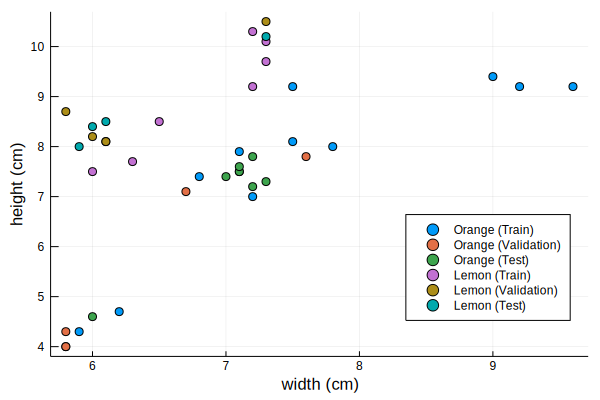

In [0]:
run(`curl -fsS https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/fruit_data -o /tmp/fruit_data.tsv`)
run(`curl -fsS https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/fruit_types.txt -o /tmp/fruit_types.txt`)

id2fruit = Dict{Int,Symbol}()
open("/tmp/fruit_types.txt") do f
    for l in eachline(f)
        idstr, description = split(l, limit=2)
        id = parse(Int, idstr)
        if occursin(r"orange"i, description) || occursin(r"mandarin"i, description)
            id2fruit[id] = :orange
        elseif occursin(r"lemon"i, description)
            id2fruit[id] = :lemon
        elseif occursin(r"apple"i, description)
            id2fruit[id] = :apple
        else
            error("Unable to detect fruit in descreption: \"$(description)\"")
        end
    end
end

labels  = Symbol[]
datatmp = Vector{Vector{Float64}}()
open("/tmp/fruit_data.tsv") do f
    for l in eachline(f)
        soup   = split(l, limit=4)
        fruit  = id2fruit[parse(Int, soup[1])]
        mass   = parse(Int, soup[2])
        height = parse(Float64, soup[3])
        width  = parse(Float64, soup[4])
        push!(labels, fruit)
        push!(datatmp, [mass, height, width])
    end
end
data = NamedArray(reduce(hcat, datatmp))
setdimnames!(data, "Attribute", 1)
setnames!(data, ["Mass", "Height", "Width"], 1)
setdimnames!(data, "Sample", 2)

run(`rm -f /tmp/fruit_data.tsv /tmp/fruit_types.txt`)
nothing

orangeidx = findall(x -> x == :orange, labels)
lemonidx  = findall(x -> x == :lemon, labels)

shuffle!(orangeidx)
orangetrainidx = orangeidx[1:Int(round(length(orangeidx)*(3/6)))]
orangevalidx = orangeidx[length(orangetrainidx):length(orangetrainidx) + Int(round(length(orangeidx)*(1/6)))]
orangetestidx = orangeidx[length(orangetrainidx) + length(orangevalidx) + 1:end]
@assert length(orangetrainidx) + length(orangevalidx) + length(orangetestidx) == length(orangeidx)

shuffle!(lemonidx)
lemontrainidx = lemonidx[1:Int(round(length(lemonidx)*(3/6)))]
lemonvalidx = lemonidx[length(lemontrainidx):length(lemontrainidx) + Int(round(length(lemonidx)*(1/6)))]
lemontestidx = lemonidx[length(lemontrainidx) + length(lemonvalidx) + 1:end]
@assert length(lemontrainidx) + length(lemonvalidx) + length(lemontestidx) == length(lemonidx)

scatter(
    [data["Height", orangetrainidx], data["Height", orangevalidx],
        data["Height", orangetestidx], data["Height", lemontrainidx],
        data["Height", lemonvalidx], data["Height", lemontestidx]],
    [data["Width", orangetrainidx], data["Width", orangevalidx],
        data["Width", orangetestidx], data["Width", lemontrainidx],
        data["Width", lemonvalidx], data["Width", lemontestidx]],
    labels=["Orange (Train)", "Orange (Validation)", "Orange (Test)",
            "Lemon (Train)", "Lemon (Validation)", "Lemon (Test)"],
        xlabel="width (cm)", ylabel="height (cm)", legend=:bottomright)

We are about to juggle plenty of models, let us introduce some structure.

In [0]:
mutable struct Perceptron
    w ::Vector{Float64}
    b ::Float64
end
Perceptron(d) = Perceptron(zeros(d), 0)
# p, for prediction
p(m::Perceptron, x) = dot(m.w, x) + m.b > 0

mperceptron = Perceptron(2)

function accuracy(oidx, lidx, m)
    correct = 0
    for i in oidx
        p(m, data[["Height", "Width"], i]) || continue
        correct += 1
    end
    for i in lidx
        !p(m, data[["Height", "Width"], i]) || continue
        correct += 1
    end
    correct/(length(oidx) + length(lidx))*100
end

@show accuracy(orangetrainidx, lemontrainidx, mperceptron)
@show accuracy(orangevalidx, lemonvalidx, mperceptron)
@show accuracy(orangetestidx, lemontestidx, mperceptron)

# `let` can be used to create a shorthand within a limited scope.
let m = mperceptron
    bestm   = deepcopy(m)
    bestacc = 0.0

    epochs = 10
    for iteration in 1:epochs
        for i in shuffle(vcat(orangetrainidx, lemontrainidx))
            x = data[2:3, i]
            isorange = i in orangeidx
            p(m, x) != isorange || continue
            if isorange
                m.w .+= x
                m.b  += 1
            else
                m.w .-= x
                m.b  -= 1
            end
        end

        @show iteration currentvalacc = accuracy(orangevalidx, lemonvalidx, m)
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end

    m.w[:] = bestm.w[:]
    m.b    = bestm.b
end

@show accuracy(orangetrainidx, lemontrainidx, mperceptron)
@show accuracy(orangevalidx, lemonvalidx, mperceptron)
@show accuracy(orangetestidx, lemontestidx, mperceptron);

accuracy(orangetrainidx, lemontrainidx, mperceptron) = 40.0
accuracy(orangevalidx, lemonvalidx, mperceptron) = 44.44444444444444
accuracy(orangetestidx, lemontestidx, mperceptron) = 36.36363636363637
iteration = 1
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 55.55555555555556
iteration = 2
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 55.55555555555556
iteration = 3
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 66.66666666666666
iteration = 4
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 100.0
iteration = 5
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 77.77777777777779
iteration = 6
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 55.55555555555556
iteration = 7
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 100.0
iteration = 8
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 55.55555555555556
iteration = 9
currentvalacc = accuracy(orangevalidx, lemonvalidx, m) = 100.0
iteration = 10
currentvalacc = accu

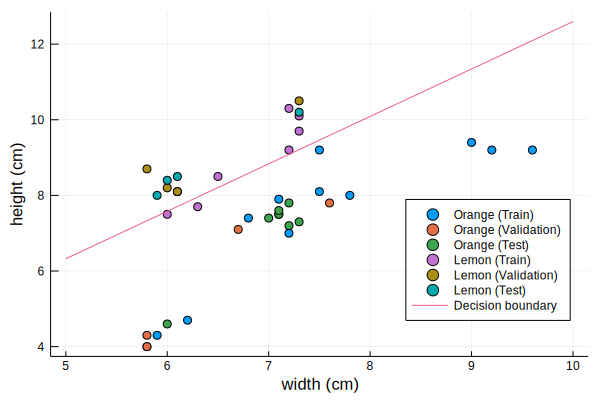

In [0]:
plt = scatter(
    [data["Height", orangetrainidx], data["Height", orangevalidx],
        data["Height", orangetestidx], data["Height", lemontrainidx],
        data["Height", lemonvalidx], data["Height", lemontestidx]],
    [data["Width", orangetrainidx], data["Width", orangevalidx],
        data["Width", orangetestidx], data["Width", lemontrainidx],
        data["Width", lemonvalidx], data["Width", lemontestidx]],
    labels=["Orange (Train)", "Orange (Validation)", "Orange (Test)",
            "Lemon (Train)", "Lemon (Validation)", "Lemon (Test)"],
        xlabel="width (cm)", ylabel="height (cm)", legend=:bottomright)
let m = mperceptron
    k = -(m.b/m.w[2])/(m.b/m.w[1])
    d(x) = k*x + (-m.b/m.w[2])
    plot!(deepcopy(plt), d, 5:10, label="Decision boundary")
end

## The logistic function ##

Frequently called “sigmoid”, which is a bit of a misnomer as it is the family of functions which it belongs to.

$$ σ(x)  = \frac{1}{1 + e^{-x}} $$

$$ σ′(x) = σ(x)(1 - σ(x)) $$

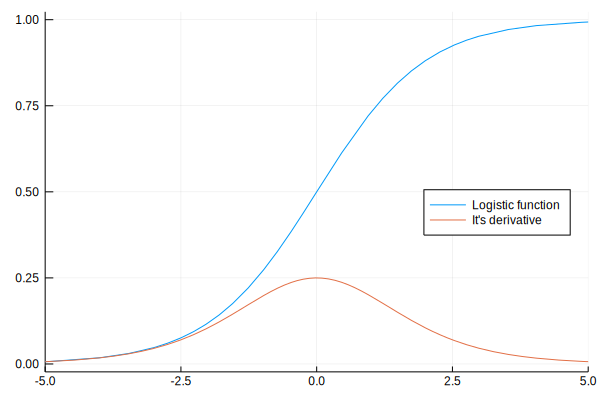

In [0]:
logistic(x)  = (1/(1 + exp(-x)))
logisticprime(x) = logistic(x)*(1 - logistic(x))

plt = plot(logistic, xlim=(-5, 5), label="Logistic function")
plot!(plt, logisticprime, xlim=(-5, 5), label="It's derivative", legend=:right)

Some observations:

$$ σ : \mathbb{R} \to [0, 1] $$

$$ σ(0) = 0.5 $$

In [0]:
# Assuming that we have evaluated `logistic(x)`, we can do the following.
logisticprime(x, fx) = fx*(1 - fx);

## Logistic regression ##

$$ x = [x_0, \ldots, x_n] $$

$$ x \in \mathbb{R}^n $$

$$ w \in \mathbb{R}^n $$

$$ b \in \mathbb{R} $$

$$ f(x) = σ(w'x + b) $$

$$ f(x) \in [0, 1] $$

$$
p(x) = \begin{cases} 
      1 & f(x) \geq 0.5 \\
      0 & else        \\
   \end{cases}
$$

In [0]:
mutable struct LogisticRegression
    w ::Vector{Float64}
    b ::Float64
end
LogisticRegression(d)       = LogisticRegression(zeros(d), 0)
f(m::LogisticRegression, x) = logistic(dot(m.w, x) + m.b)
p(m::LogisticRegression, x) = f(m, x) >= 0.5

mlogreg = LogisticRegression(2)

@show accuracy(orangetrainidx, lemontrainidx, mlogreg)
@show accuracy(orangevalidx, lemonvalidx, mlogreg)
@show accuracy(orangetestidx, lemontestidx, mlogreg);

accuracy(orangetrainidx, lemontrainidx, mlogreg) = 60.0
accuracy(orangevalidx, lemonvalidx, mlogreg) = 55.55555555555556
accuracy(orangetestidx, lemontestidx, mlogreg) = 63.63636363636363


## The perceptron revisited ##

$$ w \in \mathbb{R}^n $$

$$ b \in \mathbb{R} $$

$$
p(x) = \begin{cases} 
      1 & w'x + b > 0 \\
      0 & else        \\
   \end{cases}
$$

Update “rule” (with abused notation):

$$
u(x, y) = \begin{cases} 
        w = w + x; b = b + 1 & (p(x) \neq y )\land y     \\
        w = w - x; b = b - 1 & (p(x) \neq y)\land \neg y \\
        w = w; b = b & else                              \\
    \end{cases}
$$

$$ x \in \mathbb{R}^n $$

$$ y \in \{0, 1\} $$

Better formalism (still with abused notation):

$$ w = w + x(y - p(x)) $$

$$ b = b + y - p(x) $$

We now have a mathematical expression as opposed to an algorithm.


## Gradient-based optimisation ##

As we have already seen, the perceptron algorithm is unstable and while much of the 60s was spent exploring various learning algorithms for it they became increasingly finicky as the networks grew deeper.

### Loss or “model goodness” ###

$$ f(x) = P(y = 1|x) $$

$$ f(x) \in [0, 1] $$

From this perspective $w$ and $b$ controls the shape of a probability distribution over $x$. What is then the likelihood that this function generated our observations? Assuming independence between samples.

$$ \prod_{i} P(y_{i}=\hat{y}_{i}|x_{i}) $$

Ideally, this this product should approach $1$ for any model that fits the data “well”. We thus want to maximise this function.

$$ arg\max_{w,b} \prod_{i} P(y_{i}=\hat{y}_{i}|x_{i}) $$

$$ arg\max_{w,b} \prod_{i} P(y_{i}=0|x_{i})^{1 - y_{i}} P(y_{i}=1|x_{i})^{y_{i}} $$

$$ arg\max_{w,b} \prod_{i} (1 - σ(w'x_{i} + b))^{1 - y_{i}} σ(w'x_{i} + b)^{y_{i}} $$

$$ arg\max_{w,b} \sum_{i} \textrm{log}[(1 - σ(w'x_{i} + b))^{1 - y_{i}} σ(w'x_{i} + b)^{y_{i}}] $$

Why do we prefer this form? There are two reasons…

$$ arg\max_{w,b} \sum_{y_{i} = 0} \textrm{log}[(1 - σ(w'x_{i} + b))] + \sum_{y_{i} = 1} \textrm{log}[σ(w'x_{i} + b)] $$

As a matter of convention (historical reasons as well?), we generally minimise rather than maximise functions:

$$ arg\min_{w,b} \sum_{y_{i} = 0} -\textrm{log}[(1 - σ(w'x_{i} + b))] + \sum_{y_{i} = 1} -\textrm{log}[σ(w'x_{i} + b)] $$



$$
\small
\frac{\partial J(\theta)}{\partial \theta_j}  = 
\frac{\partial}{\partial \theta_j} \,\frac{-1}{m}\sum_{i=1}^m 
\left[ y^{(i)}\log\left(h_\theta \left(x^{(i)}\right)\right) +
(1 -y^{(i)})\log\left(1-h_\theta \left(x^{(i)}\right)\right)\right]
\\[2ex]\small\underset{\text{linearity}}= \,\frac{-1}{m}\,\sum_{i=1}^m 
\left[ 
y^{(i)}\frac{\partial}{\partial \theta_j}\log\left(h_\theta \left(x^{(i)}\right)\right) +
(1 -y^{(i)})\frac{\partial}{\partial \theta_j}\log\left(1-h_\theta \left(x^{(i)}\right)\right)
\right]
\\[2ex]\Tiny\underset{\text{chain rule}}= \,\frac{-1}{m}\,\sum_{i=1}^m 
\left[ 
y^{(i)}\frac{\frac{\partial}{\partial \theta_j}h_\theta \left(x^{(i)}\right)}{h_\theta\left(x^{(i)}\right)} +
(1 -y^{(i)})\frac{\frac{\partial}{\partial \theta_j}\left(1-h_\theta \left(x^{(i)}\right)\right)}{1-h_\theta\left(x^{(i)}\right)}
\right]
\\[2ex]\small\underset{h_\theta(x)=\sigma\left(\theta^\top x\right)}=\,\frac{-1}{m}\,\sum_{i=1}^m 
\left[ 
y^{(i)}\frac{\frac{\partial}{\partial \theta_j}\sigma\left(\theta^\top x^{(i)}\right)}{h_\theta\left(x^{(i)}\right)} +
(1 -y^{(i)})\frac{\frac{\partial}{\partial \theta_j}\left(1-\sigma\left(\theta^\top x^{(i)}\right)\right)}{1-h_\theta\left(x^{(i)}\right)}
\right]
\\[2ex]\Tiny\underset{\sigma'}=\frac{-1}{m}\,\sum_{i=1}^m 
\left[ y^{(i)}\,
\frac{\sigma\left(\theta^\top x^{(i)}\right)\left(1-\sigma\left(\theta^\top x^{(i)}\right)\right)\frac{\partial}{\partial \theta_j}\left(\theta^\top x^{(i)}\right)}{h_\theta\left(x^{(i)}\right)} -
(1 -y^{(i)})\,\frac{\sigma\left(\theta^\top x^{(i)}\right)\left(1-\sigma\left(\theta^\top x^{(i)}\right)\right)\frac{\partial}{\partial \theta_j}\left(\theta^\top x^{(i)}\right)}{1-h_\theta\left(x^{(i)}\right)}
\right]
\\[2ex]\small\underset{\sigma\left(\theta^\top x\right)=h_\theta(x)}= \,\frac{-1}{m}\,\sum_{i=1}^m 
\left[ 
y^{(i)}\frac{h_\theta\left( x^{(i)}\right)\left(1-h_\theta\left( x^{(i)}\right)\right)\frac{\partial}{\partial \theta_j}\left(\theta^\top x^{(i)}\right)}{h_\theta\left(x^{(i)}\right)} -
(1 -y^{(i)})\frac{h_\theta\left( x^{(i)}\right)\left(1-h_\theta\left(x^{(i)}\right)\right)\frac{\partial}{\partial \theta_j}\left( \theta^\top x^{(i)}\right)}{1-h_\theta\left(x^{(i)}\right)}
\right]
\\[2ex]\small\underset{\frac{\partial}{\partial \theta_j}\left(\theta^\top x^{(i)}\right)=x_j^{(i)}}=\,\frac{-1}{m}\,\sum_{i=1}^m \left[y^{(i)}\left(1-h_\theta\left(x^{(i)}\right)\right)x_j^{(i)}-
\left(1-y^{i}\right)\,h_\theta\left(x^{(i)}\right)x_j^{(i)}
\right]
\\[2ex]\small\underset{\text{distribute}}=\,\frac{-1}{m}\,\sum_{i=1}^m \left[y^{i}-y^{i}h_\theta\left(x^{(i)}\right)-
h_\theta\left(x^{(i)}\right)+y^{(i)}h_\theta\left(x^{(i)}\right)
\right]\,x_j^{(i)}
\\[2ex]\small\underset{\text{cancel}}=\,\frac{-1}{m}\,\sum_{i=1}^m \left[y^{(i)}-h_\theta\left(x^{(i)}\right)\right]\,x_j^{(i)} \\[2ex]\small=\frac{1}{m}\sum_{i=1}^m\left[h_\theta\left(x^{(i)}\right)-y^{(i)}\right]\,x_j^{(i)}
$$



We can now take the gradient with respect to $w$ and $b$, a step in the direction of the gradient brings us closer to finding the optimum.

$$ \frac{\partial J}{\partial w} = \sum_{i} x_{i}(\hat{y}_{i} - y_{i}) $$

$$ \frac{\partial J}{\partial b} = \sum_{i} \hat{y}_{i} - y_{i} $$

In practice we divide the gradient by the total number of samples, why?

In [1]:
let m = mlogreg
    bestm   = deepcopy(m)
    bestacc = 0.0
∇y
    epochs = 50
    for iteration in 1:epochs
        gradm = deepcopy(m)
        fill!(gradm.w, 0)
        gradm.b = 0

        for i in shuffle(vcat(orangetrainidx, lemontrainidx))
            x            = data[2:3, i]
          isorange     = i in orangeidx
            y            = isorange ? 1 : 0
            yprime       = f(m, x)
            gradm.w[:] .-= x*(yprime - y)
            gradm.b     -= yprime - y
        end

        gradm.w ./= length([orangetrainidx; lemontrainidx])
        gradm.b  /= length([orangetrainidx; lemontrainidx])
        m.w .+= gradm.w
        m.b  += gradm.b

        @show iteration currentvalacc = accuracy(orangevalidx, lemonvalidx, m)
        currentvalacc > bestacc || continue
        bestm   = deepcopy(m)
        bestacc = currentvalacc
    end

    m.w[:] = bestm.w[:]
    m.b    = bestm.b;
end

@show accuracy(orangetrainidx, lemontrainidx, mlogreg)
@show accuracy(orangevalidx, lemonvalidx, mlogreg)
@show accuracy(orangetestidx, lemontestidx, mlogreg);

SyntaxError: ignored

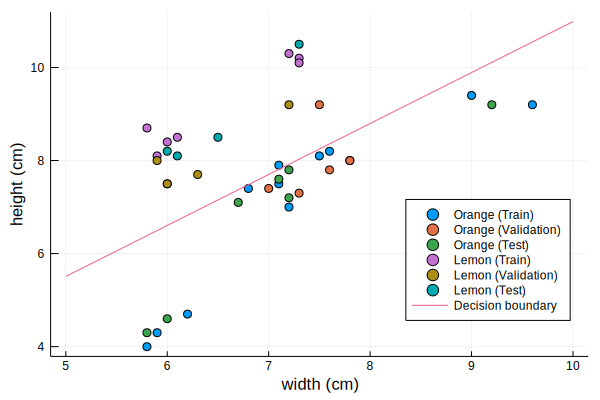

In [0]:
plt = scatter(
    [data["Height", orangetrainidx], data["Height", orangevalidx],
        data["Height", orangetestidx], data["Height", lemontrainidx],
        data["Height", lemonvalidx], data["Height", lemontestidx]],
    [data["Width", orangetrainidx], data["Width", orangevalidx],
        data["Width", orangetestidx], data["Width", lemontrainidx],
        data["Width", lemonvalidx], data["Width", lemontestidx]],
    labels=["Orange (Train)", "Orange (Validation)", "Orange (Test)",
            "Lemon (Train)", "Lemon (Validation)", "Lemon (Test)"],
        xlabel="width (cm)", ylabel="height (cm)", legend=:bottomright)
let m = mlogreg
    k = -(m.b/m.w[2])/(m.b/m.w[1])
    d(x) = k*x + (-m.b/m.w[2])
    plot!(deepcopy(plt), d, 5:10, label="Decision boundary")
end